# Creation of a graph, from a list of proteins, linking them by their belonging to common biological pathways

-Enter a list of proteins in the file liste_proteines.txt
- If you want to display all the biological process : display_all_bp=True
- If you just want to display the bp who link proteins: display_all_bp=False

In [57]:
display_all_bp=False

## Library

In [58]:
%pip install goatools

import networkx as nx
import matplotlib.pyplot as plt
import requests
from goatools import obo_parser
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Functions

In [59]:
#Function creating a dictionary with the id as the key and the GO terms of the biological pathways as the value
def create_dico_bp(list_id):
    dico_bp_b={}
    for i in list_id:
        list_temp=[]
        try:
          r=requests.get(f"http://www.ebi.ac.uk/QuickGO/services/annotation/search?geneProductId={i}")
          data=r.json()
          for j in data["results"]:
            if j["goAspect"]=="biological_process":
              if j["goId"]!= "GO:0008150":
                list_temp.append(j["goId"])
          if len(list_temp)>0:
            dico_bp_b[i]=list_temp
        except Exception as e: 
          print(e)
          print(i)

    return dico_bp_b

In [60]:
# text file including name of proteins and their biological processes
def write_list(dico_bp,go):
  with open("liste_proteines.txt","w") as f:
    for k in dico_bp.keys():
      list_bp=[]
      for v in dico_bp[k]:
        go_name=go[v].name
        list_bp.append(go_name)
      f.write(f"nom :{k}\nProcessus biologique: \n{list_bp}\n\n")
  files.download("liste_proteines.txt")


In [61]:
# function finding nearest common ancestor between 2 GB term
def deepest_common_ancestor(terms, go):
    '''
        This function gets the nearest common ancestor 
        using the above function.
        Only returns single most specific - assumes unique exists.
    '''
    # Take the element at maximum depth. 
    return max(common_parent_go_ids(terms, go), key=lambda t: go[t].depth)

In [62]:
def common_parent_go_ids(terms, go):
    '''
        This function finds the common ancestors in the GO 
        tree of the list of terms in the input.
    '''
    # Find candidates from first
    try:
      rec = go[terms[0]]
      candidates = rec.get_all_parents()
      candidates.update({terms[0]})
    
    # Find intersection with second to nth term
      for term in terms[1:]:
        rec = go[term]
        parents = rec.get_all_parents()
        parents.update({term})
        
        # Find the intersection with the candidates, and update.
        candidates.intersection_update(parents)
      return candidates
    
    except:
        print(terms)
        

In [63]:
# Graph display
def display_graph(dico_bp,go):
  G=nx.Graph()
  for k in dico_bp.keys():
    if len(dico_bp[k])>0:
      G.add_node(k)
  if display_all_bp==True:
    for v in dico_bp.values():
      for l in v:
        G.add_node(go[l].name)
    for k in dico_bp.keys():
      if len(dico_bp[k])>0:
        for v in dico_bp[k]:
          G.add_edge(k,go[v].name,weight=go[v].depth)

  for k in dico_bp.keys():
    for k1 in dico_bp.keys():
      if len(dico_bp[k])>0 and len(dico_bp[k1])>0:
        if k!=k1:
            ancestor="GO:0008150"
            for v in dico_bp[k]:
                for v2 in dico_bp[k1]:
                    new=deepest_common_ancestor([v,v2],go)
                    if go[new].depth>go[ancestor].depth:
                        ancestor=new
            if ancestor not in G.nodes():
                G.add_node(go[ancestor].name)
            G.add_edge(go[ancestor].name,k,weight=go[ancestor].depth)
            G.add_edge(go[ancestor].name,k1,weight=go[ancestor].depth)

  color_map_up=[]
  for node in G:
    if len(node) < 7:
        color_map_up.append('red')
    else: 
        color_map_up.append('green')  
        
  weights = [G[u][v]['weight'] for u,v in G.edges()]
  fig = plt.figure(1, figsize=(100, 50))
  pos = nx.spring_layout(G,scale=5)
  nx.draw(G,pos,with_labels=True,node_color=color_map_up,node_size=5000,bbox=dict(facecolor="white", edgecolor='black', boxstyle='round,pad=0.2'), width=weights,font_size=25)
  plt.savefig("Graph.png", format="PNG")
  files.download("Graph.png") 


## Results

In [64]:
list_int=[]
with open("/content/gdrive/MyDrive/Biological_process_interaction/liste_proteines.txt","r") as f:
  for l in f.readlines():
    list_int.append(l.strip())

In [65]:
#Dictionary with the goIDs in keys and the GOterms in values
go = obo_parser.GODag("/content/gdrive/MyDrive/Biological_process_interaction/go-basic.obo")

/content/gdrive/MyDrive/Biological_process_interaction/go-basic.obo: fmt(1.2) rel(2022-03-22) 47,103 Terms


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

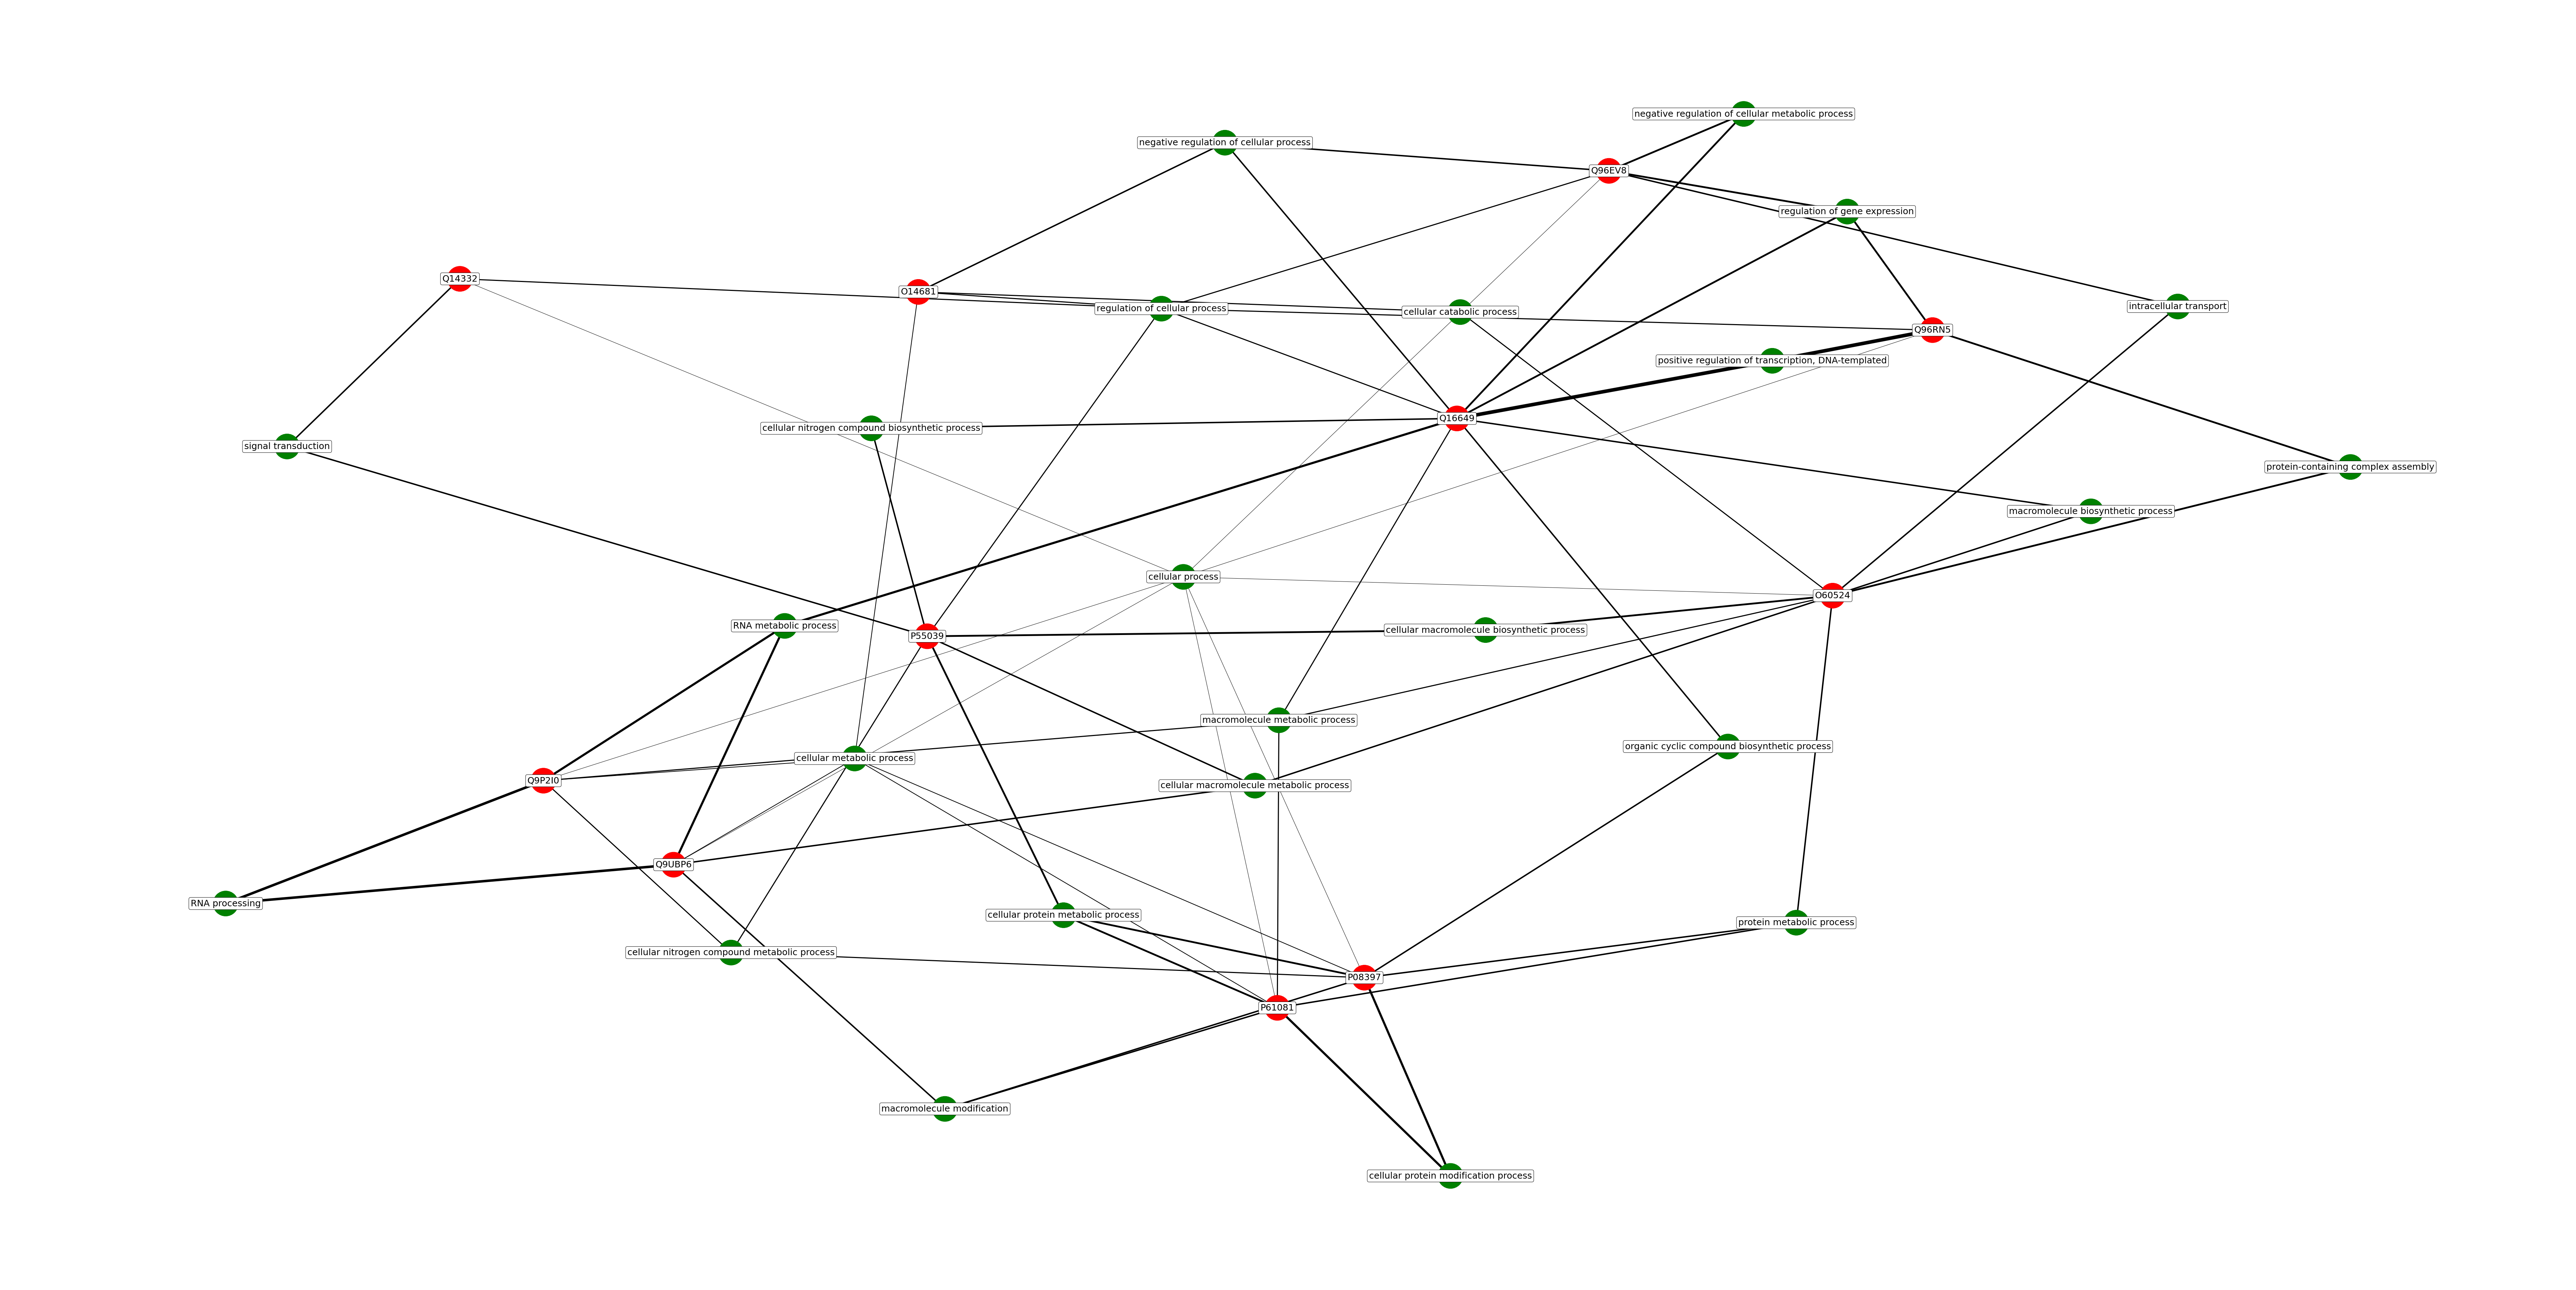

In [68]:
dico_bp= create_dico_bp(list_int)
display_graph(dico_bp,go)
write_list(dico_bp,go)
